In [3]:
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rcParams["figure.figsize"] = (20,10)

def plot_quantile_compare1(log):
    with open(log) as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            x.append(float(line.split()[0]))
            y.append(float(line.split()[1]))
            

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("size")
    plt.ylabel("t(s)")
    plt.plot(x,y,'.',color='c')
    plt.show()
    
def plot_quantile_compare_perf1(log):
    with open(log) as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            x.append(float(line.split()[0]))
            time = float(line.split()[1])
            cost = float(line.split()[2])
            y.append((cost/time)*1e-9)
            

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("size")
    plt.ylabel("GF/s")
    plt.plot(x,y,'.',color='c')
    plt.show()

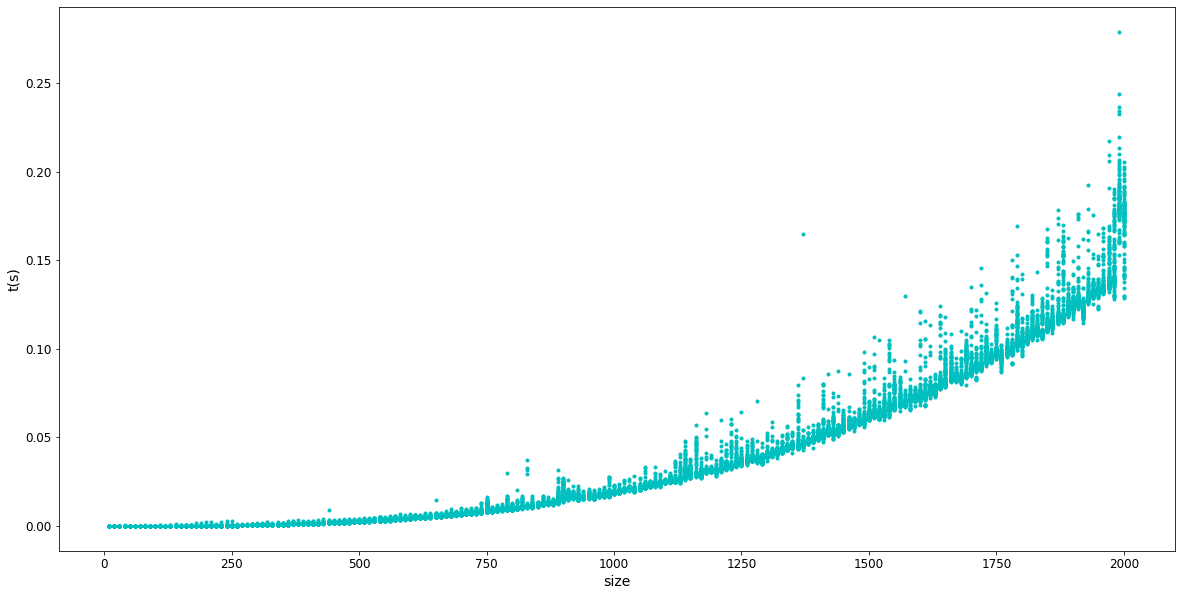

In [4]:
#plt.yscale('log')
plot_quantile_compare1("data/gemm2000.txt")

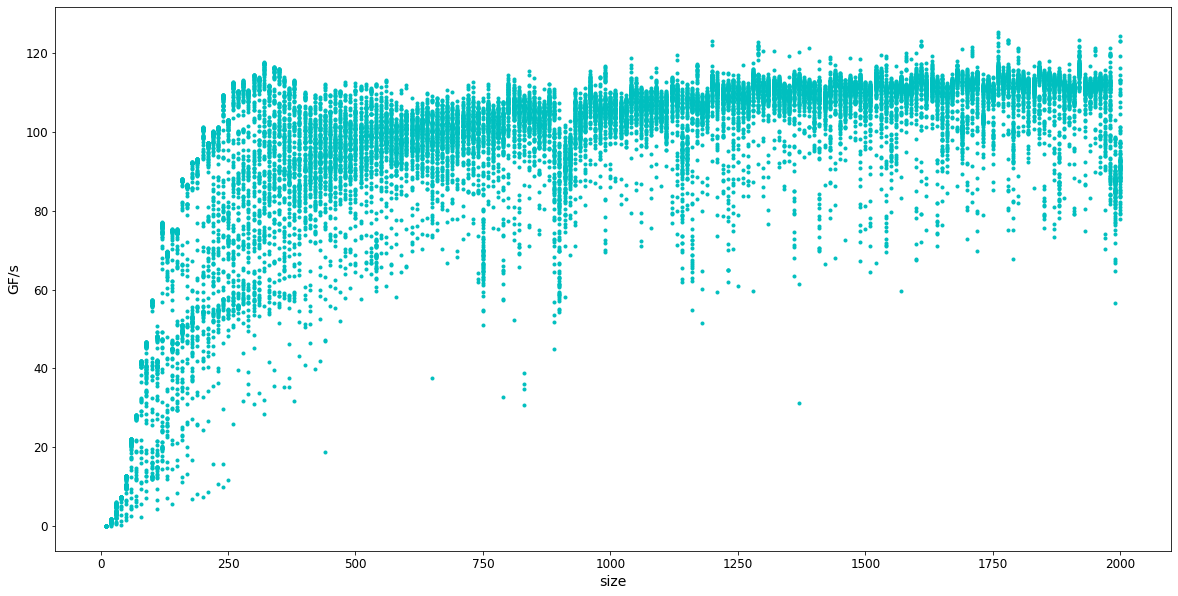

In [5]:
plot_quantile_compare_perf1("data/gemm2000.txt")

### Random seed

In [6]:
tf.random.set_seed(2252)

In [7]:
def cast_to_number(x):
    return tf.strings.to_number(x,out_type=tf.float64)

def split_features_labels(x):
    nn_input = tf.stack([x[0],x[0]**2])
    nn_gt = x[1]*1e4
    return (nn_input, nn_gt[...,tf.newaxis])

filename = "data/gemm2000_shuffled.txt"
ds_file = tf.data.TextLineDataset(filename)
ds_file = ds_file.map(tf.strings.split)
ds_file = ds_file.map(cast_to_number)
ds_file = ds_file.map(split_features_labels)

DATASET_SIZE = len(open(filename).readlines())

train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.10 * DATASET_SIZE)

train_dataset = ds_file.take(train_size)
train_dataset = train_dataset.batch(5)

test_dataset = ds_file.skip(train_size)
test_dataset = test_dataset.batch(1)

tf.keras.backend.set_floatx('float64')

In [59]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    
    self.d1 = tf.keras.layers.Dense(64, activation='relu',
                                    bias_initializer=tf.keras.initializers.Constant(0.0),
                                    kernel_initializer=tf.keras.initializers.Constant(0.0),
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                    bias_regularizer=tf.keras.regularizers.l2(0.01),
                                    input_shape=(None,2))
    
    self.d2 = tf.keras.layers.Dense(64, activation='relu',
                                bias_initializer=tf.keras.initializers.Constant(0.0),
                                kernel_initializer=tf.keras.initializers.Constant(0.0),
                                bias_regularizer=tf.keras.regularizers.l2(0.01),
                                kernel_regularizer=tf.keras.regularizers.l2(0.01))
    
    self.d3 = tf.keras.layers.Dense(1, activation=None,
                                bias_initializer=tf.keras.initializers.Constant(0.0),
                                kernel_initializer=tf.keras.initializers.Constant(0.0),
                                bias_regularizer=tf.keras.regularizers.l2(0.01),
                                kernel_regularizer=tf.keras.regularizers.l2(0.01))

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    return self.d3(x)

In [60]:
model = MyModel()
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()
mean_loss = tf.keras.metrics.Mean(name='mean_loss')

@tf.function
def train_step(x,gt):
    with tf.GradientTape() as tape:
        nn_out = model(x)
        loss_out = loss(gt, nn_out) 
        reg_loss = tf.math.add_n(model.losses)
        loss_out = loss_out + reg_loss
    gradients = tape.gradient(loss_out, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    mean_loss(loss_out)
    
def train_model():
    i = 0
    for input_x, gt_y in train_dataset:
        i = i+1
        train_step(input_x, gt_y)
        if(i%100 == 0):
            template = 'Iter {}, Loss: {}'
            print(template.format(i,mean_loss.result()))
            mean_loss.reset_states()
            
mean_loss_test = tf.keras.metrics.Mean(name='mean_loss_test')

@tf.function
def test_step(x, gt):
    nn_out = model(x)
    test_loss = loss(gt, nn_out)

    mean_loss_test(test_loss)
    
    return nn_out

def test_model():
    i = 0
    for input_x, gt_y in test_dataset:
        i = i+1
        result = test_step(input_x, gt_y)
        if(i%100 == 0):
            template = 'Iter {}, Loss: {}'
            print(template.format(i,mean_loss_test.result()))
            print(input_x.numpy(), result.numpy(), gt_y.numpy())
        mean_loss_test.reset_states()

In [61]:
train_model()

Iter 100, Loss: 343656.61542014306
Iter 200, Loss: 300778.7372335482
Iter 300, Loss: 314116.2260653416
Iter 400, Loss: 311638.7181552158
Iter 500, Loss: 350777.1002162682
Iter 600, Loss: 304126.4169418331
Iter 700, Loss: 357861.9472563511
Iter 800, Loss: 317779.3472663917
Iter 900, Loss: 317469.77143146924
Iter 1000, Loss: 337151.42999021744
Iter 1100, Loss: 336076.8352633092
Iter 1200, Loss: 397131.58468125813
Iter 1300, Loss: 265305.66291276016
Iter 1400, Loss: 331938.04887535196
Iter 1500, Loss: 297566.11330120487
Iter 1600, Loss: 343188.88501968636
Iter 1700, Loss: 323557.2457111322
Iter 1800, Loss: 333080.9726368098
Iter 1900, Loss: 291506.3339143887
Iter 2000, Loss: 299090.0749060104
Iter 2100, Loss: 343233.62363497086
Iter 2200, Loss: 302011.185907366
Iter 2300, Loss: 352949.9504000014
Iter 2400, Loss: 335794.15910365834
Iter 2500, Loss: 331920.612789014
Iter 2600, Loss: 361148.541226278
Iter 2700, Loss: 343986.8482369809
Iter 2800, Loss: 326387.0098296299
Iter 2900, Loss: 39249

### Eval

In [58]:
eval_size = 2000
inp = tf.constant([eval_size,eval_size**2],shape=(1,2),dtype="float64")
out = model(inp)
print(out)

tf.Tensor([[0.]], shape=(1, 1), dtype=float64)


In [53]:
import numpy as np
sizes = np.arange(10,2010,5)
y = []
for s in sizes:
    inp = tf.constant([s,s**2],shape=(1,2),dtype="float64")
    y.append((model(inp).numpy().reshape(-1))*1e-4*-1)

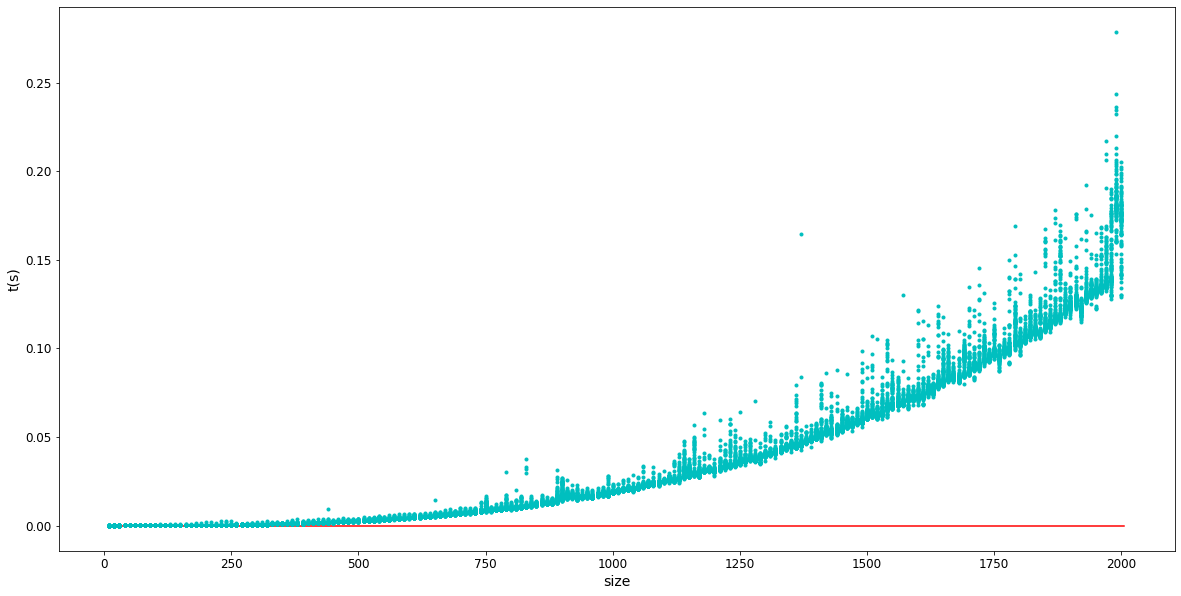

In [54]:
plt.plot(sizes,y,color='r')
plot_quantile_compare1("data/gemm2000.txt")

In [47]:
model.get_weights()

[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
     